In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import random
%matplotlib inline

df = pd.read_csv(r'C:/Users/MICK/Desktop/ML4QS/ML4QS/Python3Code/intermediate_datafiles/Crowdsignal/chapter5_result.csv')

# time as index
df.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df.index = df['Time']

# filter data and columns
cols_to_use = ['labelSitting',
              'labelStanding',
              'labelWalking',
              'labelRunning',
              'labelOnTable',
              'labelWashingHands',
              'labelDriving',
              'labelEating',
              'hr_watch_rate']

df = df[cols_to_use].dropna()

min_, max_ = df['hr_watch_rate'].min(), df['hr_watch_rate'].max()
df.loc[:, 'hr_watch_rate'] = (df['hr_watch_rate'] - min_) / (max_ - min_)

In [2]:
def get_periods(df, labels):
    dataset = {'Train': [], 'Test': []}
    for lab in labels:
        dflab = df[df[lab] == 1]
        dflab['timeframe'] = continuous_timeframes(dflab.reset_index()['Time'].diff())
        dflab['splitTimeframe'] = split_timeframes(dflab['timeframe'])
        dflab = dflab.reset_index()[['hr_watch_rate', 'splitTimeframe']]
        
        trainid = random.sample(list(dflab['splitTimeframe'].unique()), int(dflab['splitTimeframe'].max()*0.6))
        testid = set(dflab['splitTimeframe'].unique()).difference(set(trainid))
        
        dataset['Train'].append((lab, [dflab[dflab['splitTimeframe'] == i] for i in trainid]))
        dataset['Test'].append((lab, [dflab[dflab['splitTimeframe'] == i] for i in testid]))
        
    return dataset


def split_timeframes(tfcol):
    new_col = []
    j = 0
    
    for val in tfcol.unique():
        valcol = tfcol[tfcol == val].reset_index()        
        new_col.extend(((valcol.index / 20) + j).astype(int))
        j = max(new_col)
                
    return new_col


def continuous_timeframes(dtcol):
    new_col = []
    i = 0
    for dt in dtcol:
        if dt > pd.Timedelta('0 days 00:00:03.00000'):
            i += 1
            new_col.append(i)
        else:  # dt < pd.Timedelta('0 days 00:00:03.00000'):
            new_col.append(i)
    return new_col

In [3]:
dataset = get_periods(df, ['labelWalking', 'labelRunning'])

C:\Users\MICK\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\MICK\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
class Model:
    def __init__(self, dataset):
        self.n_constants = 24
        self.train = dataset['Train']
        self.test = dataset['Test']
        self.labels = ['labelWalking', 'labelRunning',
                      'labelOnTable', 'labelWashingHands',
                      'labelDriving', 'labelEating',
                      'labelSitting', 'labelStanding']

    def predict(self, c, train=True):      
        p = []
        target = []

        
        if train == True:
            dataset = self.train
        else:
            dataset = self.test
        
        for label, data in dataset:
            l = [0, 0, 0, 0, 0, 0, 0, 0]
            l[self.labels.index(label)] = 1

            for seq in data:
                y = seq['hr_watch_rate'].values
                p.append(y[0])
                
                for i, timepoint in enumerate(y[1:]):
                    
                    max_inc = 1 - p[-1]
                    max_dec = p[-1]
                    
                    
                    con0p = c[0]*((c[1] - p[-1]) > 0)
                    con0n = c[2]*((c[3] - p[-1]) < 0)
                    sin0p = np.sin((i-c[4]*np.pi)/c[5])*c[6]*(np.sin((i-c[4]*np.pi) > 0))
                    sin0n = np.sin((i-c[4]*np.pi)/c[5])*c[6]*(np.sin((i-c[4]*np.pi) < 0))
                                                              
                    con1p = c[12]*((c[13] - p[-1]) > 0)
                    con1n = c[14]*((c[15] - p[-1]) < 0)
                    sin1p = np.sin((i-c[16]*np.pi)/c[17])*c[18]*(np.sin((i-c[19]*np.pi) > 0))
                    sin1n = np.sin((i-c[16]*np.pi)/c[17])*c[18]*(np.sin((i-c[19]*np.pi) < 0))
                    
                    
                    pred = p[-1] + \
                           l[0] * (max_inc*con0p*sin0p + max_dec*con0n*sin0n) +\
                           l[1] * (max_inc*con1p*sin1p + max_dec*con1n*sin1n)
    
                    p.append(pred)
                
                target.extend(y)

                
        fitness = mse(target, p)**(0.5)
        
        return fitness, p, target

MOD = Model(dataset)

In [16]:
class Individual:
    def __init__(self):
        self.age = 0
        self.n_constants = MOD.n_constants
        self.constants = list()
        self.fitness = None
        self.time = None
        self.children = 0
        self.parents = None
        self.pred = None
        self.target = None
        self.labels = None
        self.seqs = None

    def set_constants(self, constants=None):
        if constants is None:
            self.constants = np.random.random(self.n_constants)
        else:
            self.constants = constants

    def evaluate(self):
        self.fitness, self.pred, self.target = MOD.predict(c=self.constants)

    def birthday(self):
        self.age += 1

    def mutate(self, mutation_rate):
        for i, constant in enumerate(self.constants):
            if np.random.random() <= mutation_rate:
                self.constants[i] = np.random.random()


class Population:
    def __init__(self, size=5):
        self.individuals = list()
        self.size = size
        self.generation = 1
        self.mutation_rate = 0.1
        self.mean_age = None
        self.mean_children = None
        self.mean_fit = None
        self.max_fit = None
        self.worst_fit = None
        self.var = None
        self.mean_fit_history = list()
        self.max_fit_history = list()
        self.worst_fit_history = list()
        self.var_history = list()
        self.best_individual = None

    def append(self, individual):
        self.individuals.append(individual)

    def extend(self, population):
        self.individuals.extend(population)
        self.update_stats()

    def kill(self, individual):
        self.individuals.remove(individual)

    def get_best(self):
        for individual in self.individuals:
            if self.best_individual:
                if individual.fitness < self.best_individual.fitness:
                    self.best_individual = individual
            else:
                self.best_individual = individual

        return self.best_individual

    def update_stats(self):
        population_fit = [i.fitness for i in self.individuals]
        self.var = np.var(population_fit)
        self.mean_fit = np.mean(population_fit)
        self.max_fit = np.min(population_fit)
        self.worst_fit = np.max(population_fit)
        self.mean_age = np.mean([i.age for i in self.individuals])
        self.mean_children = np.mean([i.children for i in self.individuals])
        self.best_individual = self.get_best()

    def display_population(self):
        for i, individual in enumerate(self.individuals):
            if individual.parents is not None:
                parent1, parent2 = individual.parents
                mean_parents = (parent1.fitness + parent2.fitness) / 2
            else:
                mean_parents = 0
            print(i, ': fitness =', round(individual.fitness, 4), 'age =', individual.age,
                  'children =', individual.children, 'parent_fit =', round(mean_parents, 2))

        print('Mean fitness:', round(self.mean_fit, 4), 'Mean age:', round(self.mean_age, 2),
              'Mean children =', round(self.mean_children, 2), '\n')

    def initialize(self):
        for i in range(self.size):
            individual = Individual()
            individual.set_constants()
            individual.evaluate()
            individual.birthday()
            self.individuals.append(individual)

        self.best_individual = self.get_best()
        self.update_stats()
        self.display_population()
        self.mean_fit_history.append(self.mean_fit)
        self.max_fit_history.append(self.max_fit)
        self.worst_fit_history.append(self.worst_fit)
        self.var_history.append(self.var)

    def select_parents(self, n, type_='random'):
        if type_ == 'random':
            return random.sample(self.individuals, n)
        elif type_ == 'fit':
            pop_fitness = [abs(individual.fitness - self.worst_fit) for individual in self.individuals]
            probabilities = [(fit / sum(pop_fitness)) for fit in pop_fitness]
            return np.random.choice(self.individuals, size=n, replace=False, p=probabilities)
        elif type_ == 'rank':
            pop_fitness = [abs(individual.fitness - self.worst_fit) for individual in self.individuals]
            ranks = [sorted(pop_fitness).index(ind) + 1 for ind in pop_fitness]
            probabilities = [rank / sum(ranks) for rank in ranks]
            return np.random.choice(self.individuals, size=n, replace=False, p=probabilities)

    def trim(self, type_='fit', elitist=False):
        size = self.size
        new_individuals = list()
        if elitist:
            best = self.get_best()
            best.evaluate()
            size -= 1
            new_individuals.append(best)

        if type_ == 'random':
            new_individuals = random.sample(self.individuals, size)
        elif type_ == 'fit':
            pop_fitness = [abs(individual.fitness - self.worst_fit) for individual in self.individuals]
            probabilities = [(fit / sum(pop_fitness)) for fit in pop_fitness]
            new_individuals = list(np.random.choice(self.individuals, size=size, replace=False, p=probabilities))
        elif type_ == 'rank':
            pop_fitness = [abs(individual.fitness - self.worst_fit) for individual in self.individuals]
            ranks = [(sorted(pop_fitness).index(ind) + 1) for ind in pop_fitness]
            probabilities = [rank / sum(ranks) for rank in ranks]
            new_individuals = list(np.random.choice(self.individuals, size=size, replace=False, p=probabilities))

        self.individuals = new_individuals

        self.update_stats()

    def sex(self, selection_type='fit'):
        parent1, parent2 = self.select_parents(2, type_=selection_type)
        child1 = np.zeros(parent1.n_constants)
        child2 = np.zeros(parent1.n_constants)

        for i, row in enumerate(child1):
            if np.random.random() <= .5:
                child1[i] = parent1.constants[i]
                child2[i] = parent1.constants[i]
            else:
                child1[i] = parent2.constants[i]
                child2[i] = parent2.constants[i]

        children = [child1, child2]

        for child_constants in children:
            child = Individual()
            child.set_constants(child_constants)
            child.mutate(mutation_rate=self.mutation_rate)
            child.evaluate()
            child.parents = (parent1, parent2)
            self.individuals.append(child)

            parent1.children += 1
            parent2.children += 1

    def mutation_rate_change(self, type_='exp'):
        if type_ == 'linear':
            self.mutation_rate -= 0.01
        elif type_ == 'exp':
            self.mutation_rate *= 0.999
        elif type_ == 'log':
            self.mutation_rate = np.log(self.mutation_rate)

    def next_generation(self):
        self.generation += 1
        for individual in self.individuals:
            individual.birthday()
        self.mean_fit_history.append(self.mean_fit)
        self.max_fit_history.append(self.max_fit)
        self.worst_fit_history.append(self.worst_fit)
        self.var_history.append(self.var)

    def plot_generations(self):
        plt.clf()
        plt.style.use('seaborn')
        plt.figure(figsize=(5, 5))

        x = np.linspace(0, self.generation, self.generation)
        y, error = np.array(self.mean_fit_history), np.array(self.var_history)

        plt.plot(x, y, 'k', label='Mean', color='#CC4F1B')
        plt.fill_between(x, y - error, y + error,
                         alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

        plt.plot(self.max_fit_history, label="Best", color='#88CC1B')
        plt.plot(self.worst_fit_history, label='Worst', color='#CC1B1B')
        #plt.ylim((0, 0.4))
        plt.ylabel('rmse')
        plt.xlabel('Generation')
        plt.legend()
        plt.show()


def main(size=5, generations=5, children_per_gen=5, population=None):
    if population is None:
        population = Population(size)
        population.initialize()
    elif population.size < size:
        for j in range(int(size - population.size/2)):
            population.sex(selection_type='rank')
        population.size = size
        population.trim()
    elif population.size > size:
        population.size = size
        population.trim()

    for i in range(generations):
        print('Generation:', population.generation)

        for j in range(children_per_gen):
            population.sex(selection_type='rank')

        population.trim(type_='rank', elitist=False)
        population.display_population()
        population.mutation_rate_change()
        population.next_generation()

    population.plot_generations()
    return population

0 : fitness = 0.238 age = 1 children = 0 parent_fit = 0
1 : fitness = 0.2649 age = 1 children = 0 parent_fit = 0
2 : fitness = 0.1847 age = 1 children = 0 parent_fit = 0
3 : fitness = 0.2548 age = 1 children = 0 parent_fit = 0
4 : fitness = 0.2648 age = 1 children = 0 parent_fit = 0
5 : fitness = 0.3105 age = 1 children = 0 parent_fit = 0
6 : fitness = 0.1822 age = 1 children = 0 parent_fit = 0
7 : fitness = 0.2962 age = 1 children = 0 parent_fit = 0
8 : fitness = 0.268 age = 1 children = 0 parent_fit = 0
9 : fitness = 0.436 age = 1 children = 0 parent_fit = 0
10 : fitness = 0.1225 age = 1 children = 0 parent_fit = 0
11 : fitness = 0.1158 age = 1 children = 0 parent_fit = 0
12 : fitness = 0.1871 age = 1 children = 0 parent_fit = 0
13 : fitness = 0.1936 age = 1 children = 0 parent_fit = 0
14 : fitness = 0.1186 age = 1 children = 0 parent_fit = 0
15 : fitness = 0.1165 age = 1 children = 0 parent_fit = 0
16 : fitness = 0.2573 age = 1 children = 0 parent_fit = 0
17 : fitness = 0.1543 age =

0 : fitness = 0.1149 age = 0 children = 2 parent_fit = 0.12
1 : fitness = 0.1169 age = 0 children = 0 parent_fit = 0.12
2 : fitness = 0.1277 age = 0 children = 0 parent_fit = 0.13
3 : fitness = 0.1186 age = 3 children = 8 parent_fit = 0
4 : fitness = 0.1157 age = 0 children = 0 parent_fit = 0.12
5 : fitness = 0.1258 age = 0 children = 0 parent_fit = 0.12
6 : fitness = 0.14 age = 1 children = 4 parent_fit = 0.14
7 : fitness = 0.1256 age = 1 children = 8 parent_fit = 0.13
8 : fitness = 0.1324 age = 1 children = 2 parent_fit = 0.13
9 : fitness = 0.1212 age = 2 children = 4 parent_fit = 0.22
10 : fitness = 0.1187 age = 0 children = 2 parent_fit = 0.12
11 : fitness = 0.1161 age = 0 children = 0 parent_fit = 0.13
12 : fitness = 0.1229 age = 3 children = 6 parent_fit = 0
13 : fitness = 0.1221 age = 0 children = 4 parent_fit = 0.14
14 : fitness = 0.1283 age = 0 children = 2 parent_fit = 0.14
15 : fitness = 0.1188 age = 1 children = 2 parent_fit = 0.13
16 : fitness = 0.1325 age = 3 children = 2

0 : fitness = 0.1184 age = 2 children = 4 parent_fit = 0.13
1 : fitness = 0.1164 age = 0 children = 0 parent_fit = 0.12
2 : fitness = 0.1152 age = 1 children = 6 parent_fit = 0.12
3 : fitness = 0.1153 age = 1 children = 0 parent_fit = 0.12
4 : fitness = 0.1836 age = 0 children = 0 parent_fit = 0.12
5 : fitness = 0.1166 age = 1 children = 2 parent_fit = 0.12
6 : fitness = 0.119 age = 0 children = 0 parent_fit = 0.11
7 : fitness = 0.1485 age = 0 children = 0 parent_fit = 0.12
8 : fitness = 0.1149 age = 2 children = 4 parent_fit = 0.12
9 : fitness = 0.1176 age = 0 children = 2 parent_fit = 0.12
10 : fitness = 0.1196 age = 0 children = 0 parent_fit = 0.12
11 : fitness = 0.1137 age = 1 children = 6 parent_fit = 0.12
12 : fitness = 0.1134 age = 0 children = 0 parent_fit = 0.12
13 : fitness = 0.1149 age = 3 children = 6 parent_fit = 0.12
14 : fitness = 0.1163 age = 0 children = 4 parent_fit = 0.12
15 : fitness = 0.1166 age = 2 children = 8 parent_fit = 0.12
16 : fitness = 0.1178 age = 0 child

0 : fitness = 0.1196 age = 2 children = 0 parent_fit = 0.12
1 : fitness = 0.1137 age = 0 children = 2 parent_fit = 0.11
2 : fitness = 0.1146 age = 2 children = 10 parent_fit = 0.11
3 : fitness = 0.1166 age = 0 children = 0 parent_fit = 0.12
4 : fitness = 0.1142 age = 2 children = 6 parent_fit = 0.11
5 : fitness = 0.1156 age = 0 children = 0 parent_fit = 0.11
6 : fitness = 0.1152 age = 4 children = 12 parent_fit = 0.12
7 : fitness = 0.1146 age = 1 children = 8 parent_fit = 0.11
8 : fitness = 0.1147 age = 2 children = 6 parent_fit = 0.12
9 : fitness = 0.1137 age = 4 children = 12 parent_fit = 0.12
10 : fitness = 0.114 age = 0 children = 0 parent_fit = 0.11
11 : fitness = 0.1156 age = 0 children = 0 parent_fit = 0.11
12 : fitness = 0.1142 age = 2 children = 2 parent_fit = 0.12
13 : fitness = 0.1161 age = 1 children = 0 parent_fit = 0.11
14 : fitness = 0.1146 age = 2 children = 6 parent_fit = 0.12
15 : fitness = 0.1151 age = 0 children = 0 parent_fit = 0.11
16 : fitness = 0.1188 age = 0 ch

0 : fitness = 0.1147 age = 0 children = 0 parent_fit = 0.12
1 : fitness = 0.1148 age = 1 children = 6 parent_fit = 0.11
2 : fitness = 0.1146 age = 5 children = 12 parent_fit = 0.12
3 : fitness = 0.1154 age = 0 children = 0 parent_fit = 0.11
4 : fitness = 0.1153 age = 2 children = 2 parent_fit = 0.11
5 : fitness = 0.1142 age = 0 children = 2 parent_fit = 0.11
6 : fitness = 0.1154 age = 0 children = 0 parent_fit = 0.11
7 : fitness = 0.1139 age = 2 children = 6 parent_fit = 0.11
8 : fitness = 0.1146 age = 0 children = 2 parent_fit = 0.12
9 : fitness = 0.1141 age = 1 children = 0 parent_fit = 0.11
10 : fitness = 0.1153 age = 0 children = 0 parent_fit = 0.11
11 : fitness = 0.1143 age = 4 children = 14 parent_fit = 0.11
12 : fitness = 0.1151 age = 2 children = 0 parent_fit = 0.12
13 : fitness = 0.1147 age = 4 children = 8 parent_fit = 0.11
14 : fitness = 0.1149 age = 0 children = 0 parent_fit = 0.12
15 : fitness = 0.115 age = 0 children = 0 parent_fit = 0.11
16 : fitness = 0.1135 age = 0 chi

0 : fitness = 0.1135 age = 0 children = 0 parent_fit = 0.12
1 : fitness = 0.1148 age = 1 children = 4 parent_fit = 0.11
2 : fitness = 0.1142 age = 0 children = 4 parent_fit = 0.11
3 : fitness = 0.1149 age = 0 children = 0 parent_fit = 0.11
4 : fitness = 0.1194 age = 1 children = 2 parent_fit = 0.11
5 : fitness = 0.1165 age = 0 children = 0 parent_fit = 0.11
6 : fitness = 0.1128 age = 5 children = 16 parent_fit = 0.12
7 : fitness = 0.1134 age = 3 children = 6 parent_fit = 0.11
8 : fitness = 0.1149 age = 0 children = 0 parent_fit = 0.11
9 : fitness = 0.1187 age = 0 children = 0 parent_fit = 0.12
10 : fitness = 0.1139 age = 4 children = 12 parent_fit = 0.11
11 : fitness = 0.1137 age = 1 children = 0 parent_fit = 0.12
12 : fitness = 0.115 age = 1 children = 2 parent_fit = 0.12
13 : fitness = 0.1145 age = 1 children = 6 parent_fit = 0.11
14 : fitness = 0.1148 age = 3 children = 2 parent_fit = 0.11
15 : fitness = 0.1132 age = 0 children = 0 parent_fit = 0.12
16 : fitness = 0.1137 age = 6 chi

0 : fitness = 0.1132 age = 4 children = 8 parent_fit = 0.12
1 : fitness = 0.1142 age = 1 children = 0 parent_fit = 0.11
2 : fitness = 0.1135 age = 3 children = 10 parent_fit = 0.12
3 : fitness = 0.1137 age = 4 children = 8 parent_fit = 0.12
4 : fitness = 0.1135 age = 0 children = 2 parent_fit = 0.11
5 : fitness = 0.1145 age = 4 children = 10 parent_fit = 0.11
6 : fitness = 0.113 age = 7 children = 24 parent_fit = 0.11
7 : fitness = 0.1162 age = 0 children = 0 parent_fit = 0.11
8 : fitness = 0.1134 age = 0 children = 2 parent_fit = 0.11
9 : fitness = 0.1147 age = 6 children = 12 parent_fit = 0.12
10 : fitness = 0.1129 age = 2 children = 8 parent_fit = 0.11
11 : fitness = 0.1131 age = 2 children = 12 parent_fit = 0.12
12 : fitness = 0.1145 age = 0 children = 0 parent_fit = 0.11
13 : fitness = 0.1135 age = 5 children = 6 parent_fit = 0.12
14 : fitness = 0.1147 age = 2 children = 0 parent_fit = 0.11
15 : fitness = 0.1128 age = 2 children = 2 parent_fit = 0.11
16 : fitness = 0.1132 age = 3 

0 : fitness = 0.1147 age = 3 children = 4 parent_fit = 0.11
1 : fitness = 0.1142 age = 4 children = 4 parent_fit = 0.11
2 : fitness = 0.1135 age = 8 children = 10 parent_fit = 0.12
3 : fitness = 0.1152 age = 1 children = 0 parent_fit = 0.11
4 : fitness = 0.113 age = 1 children = 0 parent_fit = 0.11
5 : fitness = 0.1135 age = 6 children = 20 parent_fit = 0.12
6 : fitness = 0.1157 age = 0 children = 2 parent_fit = 0.11
7 : fitness = 0.1153 age = 0 children = 2 parent_fit = 0.11
8 : fitness = 0.113 age = 1 children = 4 parent_fit = 0.11
9 : fitness = 0.1127 age = 0 children = 0 parent_fit = 0.12
10 : fitness = 0.1155 age = 1 children = 4 parent_fit = 0.11
11 : fitness = 0.1134 age = 1 children = 6 parent_fit = 0.11
12 : fitness = 0.1523 age = 0 children = 2 parent_fit = 0.11
13 : fitness = 0.115 age = 1 children = 2 parent_fit = 0.11
14 : fitness = 0.1148 age = 0 children = 0 parent_fit = 0.11
15 : fitness = 0.1166 age = 0 children = 0 parent_fit = 0.11
16 : fitness = 0.1134 age = 1 child

0 : fitness = 0.1141 age = 1 children = 4 parent_fit = 0.11
1 : fitness = 0.1138 age = 1 children = 2 parent_fit = 0.11
2 : fitness = 0.1124 age = 3 children = 8 parent_fit = 0.11
3 : fitness = 0.1147 age = 6 children = 6 parent_fit = 0.11
4 : fitness = 0.1146 age = 0 children = 0 parent_fit = 0.11
5 : fitness = 0.1136 age = 1 children = 4 parent_fit = 0.11
6 : fitness = 0.1136 age = 4 children = 14 parent_fit = 0.12
7 : fitness = 0.113 age = 2 children = 8 parent_fit = 0.11
8 : fitness = 0.1394 age = 0 children = 0 parent_fit = 0.11
9 : fitness = 0.1148 age = 0 children = 0 parent_fit = 0.11
10 : fitness = 0.1132 age = 5 children = 8 parent_fit = 0.11
11 : fitness = 0.1131 age = 5 children = 16 parent_fit = 0.11
12 : fitness = 0.113 age = 4 children = 10 parent_fit = 0.11
13 : fitness = 0.1136 age = 6 children = 14 parent_fit = 0.11
14 : fitness = 0.1129 age = 1 children = 4 parent_fit = 0.11
15 : fitness = 0.1134 age = 4 children = 8 parent_fit = 0.11
16 : fitness = 0.1132 age = 1 ch

<Figure size 576x396 with 0 Axes>

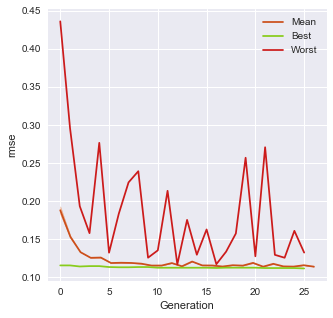

In [32]:
population = main(size=50, generations=25, children_per_gen=25)

In [33]:
ind = population.best_individual

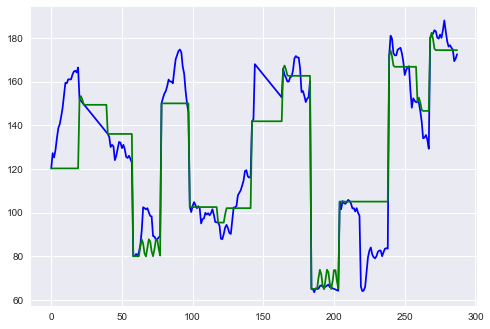

In [34]:
plt.plot((np.array(ind.target)*(max_ - min_) + min_), color='blue')
plt.plot((np.array(ind.pred)*(max_ - min_) + min_), color='green')

In [35]:
f, p, t = MOD.predict(ind.constants, train=False)

[]

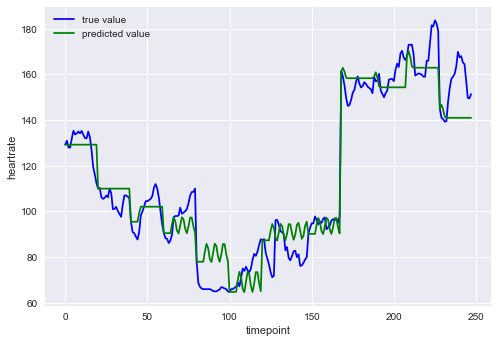

In [36]:
plt.plot((np.array(t)*(max_ - min_) + min_), color='blue', label='true value')
plt.plot((np.array(p)*(max_ - min_) + min_), color='green', label='predicted value')
plt.xlabel('timepoint')
plt.ylabel('heartrate')
plt.legend()
plt.plot()

In [37]:
mse(np.array(t)*(max_ - min_) + min_, np.array(p)*(max_ - min_) + min_)**0.5

9.740391975889507

In [12]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f